<a href="https://colab.research.google.com/github/pablovitoria/business_analysis_structured_data/blob/main/scripts/A1%3A%20Modeling%20Case%20Study%20-%20Bike%20Rentals%20in%20Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike-Sharing Demand in Chicago: Patterns, Drivers, and Demand Forecasting


This analysis examines bike rental demand patterns in Chicago to understand key drivers like weather variables and to identify opportunities for operational optimisation. The findings show that bike rentals are primarily driven by commuting behavior on working days, with clear peak-hour demand patterns, while leisure and discretionary trips play a secondary but meaningful role on weekends and non-working days.

Weather conditions significantly influence demand, with temperature being the most important weather predictor, followed by precipitation and wind effects. Warmer and drier conditions consistently support higher demand. A regression tree analysis identifies low-demand periods to recommend bike maintenance. The most notable period is late-night and early-morning hours during cold conditions, that together account for more than 10% of observations and exhibit substantially lower than average demand. These predictable low-usage windows provide clear opportunities for scheduling bike maintenance while minimizing disruption to riders.

Overall, the results highlight how understanding demand drivers and usage segmentation can support more efficient service planning, maintenance scheduling, and system reliability for the City of Chicago. In addition, a stable regression model is provided to support real-time bike rental demand prediction.


## Context
Chicago’s public bike-sharing system, Divvy Bikes, began operating in 2013, with Lyft assuming ownership in 2019. Since then, Divvy has become a core component of the city’s urban mobility infrastructure and is now the second-largest and one of the most successful bicycle sharing systems (BSS) in the United States (Bergman et al., 2024).

# Commuting: the Primary Use of Chicago’s Public Bike-Sharing System
The majority of bike rentals in Chicago are **primarily driven by commuting behavior** on working days, while leisure and discretionary usage plays a secondary but still meaningful role, mainly on non-working days. Average rental demand is higher on working days (\~725 rentals) than on non-working days (\~676 rentals), indicating a consistent baseline of work/school-related trips (Figure 1). Analysis on timing patterns reinforce this conclusion, as rentals spike sharply during peak commuting hours on working days, a classic indicator of demand driven by school and work commuters (Figure 2). This finding is consistent with prior research by Yang et al. (2019), who show that commuters account for the largest share of bike-share usage (45.58% of all Transit app unlocks) and generally follow pronounced peak-hour commuting patterns. During weekends, ridership seems to be more regular across time, probably corresponding to leisure or recreational trips (Yang et al., 2019).


Weather sensitivity analysis provides further findings. Although rainfall significantly reduces overall bike demand, rentals on working days remain comparatively resilient under adverse weather conditions (Figure 3). In particular, during light rainfall, average rentals on working days remain substantially higher than on non-working days, indicating that commuting trips are less affected by weather than leisure or exercise trips.

As a conclusion, while trip purpose cannot be directly observed in the dataset, the consistent alignment of weekday demand levels, peak-hour timing, and reduced weather sensitivity strongly suggests that commuting represents the primary use case of Chicago’s public bike-sharing system.




In [1]:
# Notebook set-up
# Cloning GitHub Repo
!git clone https://github.com/pablovitoria/business_analysis_structured_data

# Changing directory
import os
repo_name = '/content/business_analysis_structured_data'
os.chdir(repo_name)

# Checking results
print(f"Current working directory changed to: {os.getcwd()}")

fatal: destination path 'business_analysis_structured_data' already exists and is not an empty directory.
Current working directory changed to: /content/business_analysis_structured_data


In [2]:
# Importing packages
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data viz
import seaborn as sns                                # enhanced data viz
import statsmodels.formula.api as smf                # linear modeling
from sklearn.model_selection import train_test_split # train/test split
from sklearn.preprocessing import StandardScaler     # standarize variables
import sklearn.linear_model                          # faster linear modeling
from sklearn.tree import DecisionTreeRegressor       # regression trees
from sklearn.tree import plot_tree                   # tree plots
import numpy as np                                   # mathematical essentials\
import warnings

# Suppressing user warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Storing the path to the dataset
file = "./datasets/bike_rentals.xlsx"


# Reading the file into Python through pandas
bikerentals = pd.read_excel(io = file,
                            usecols = range(1, 15)) # omitting ID column

In [3]:
# Better dataframe readability:
# Making all column names lowercase and replace spaces with underscores
bikerentals.columns = (
                        bikerentals.columns
                        .str.lower()            #lowercase
                        .str.replace(" ", "_")  #replace spaces
                        )

# Making holiday a boolean
bikerentals["holiday"] = (
                          bikerentals["holiday"]
                          .map({"Yes": 1, "No": 0}))

In [4]:
# Creating new variable to identify working days
# Working day = during the week and not a holiday
# Will be used as a proxy to identify commuters
bikerentals["is_working_day"] = (
    (bikerentals["day_of_week"] != "Saturday") &
    (bikerentals["day_of_week"] != "Sunday") &
    (bikerentals["holiday"] == 0)
).astype(int)

In [5]:
# # Setting up figures style and size consistent for all notebook
sns.set_theme(style="ticks", # white background and small tick marks
              palette="colorblind") # better color for all

plt.rcParams.update({
    "figure.figsize": (8, 6),
    "axes.titlepad": 12,  # space between title and plot
    "axes.labelpad": 8, # space between axis labels and axes
    "axes.titlesize": 13,
    "axes.labelsize": 11
})

# Better visibility for mean visualization in histograms
mp = {
    "markerfacecolor": "black",
    "markeredgecolor": "black",
    "markersize": 6
}

## Figure 1: Bike Rentals: Working vs. Non-Working Days

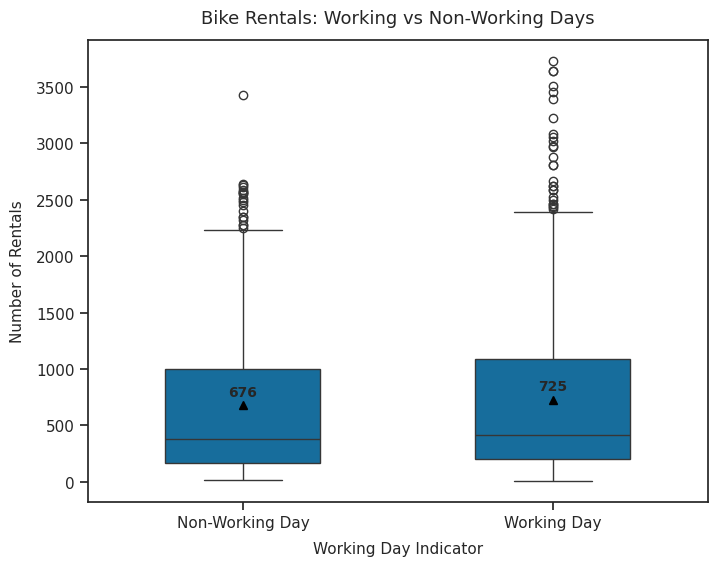

In [6]:
# Understanding if there is a difference between working and non-working days
ax = sns.boxplot(
    x='is_working_day',
    y='rentals',
    data=bikerentals,
    showmeans=True,
    meanprops=mp,
    width=0.5 # narrower width of the histogram
)

# x-axis labels
ax.set_xticklabels(["Non-Working Day", "Working Day"])

plt.title("Bike Rentals: Working vs Non-Working Days")
plt.xlabel("Working Day Indicator")
plt.ylabel("Number of Rentals")

# Compute means to see exact value
means = bikerentals.groupby("is_working_day")["rentals"].mean()

# Annotate means on the plot
for i, mean_val in enumerate(means):
    ax.text(
        i,                 # x position
        mean_val *1.12,    # y position (adding 12% padding)
        f"{mean_val:.0f}", # Round the number shown to 0
        ha="center",       # horizontal aligned center
        fontsize=10,
        fontweight="bold"  # bold text
    )

plt.show()

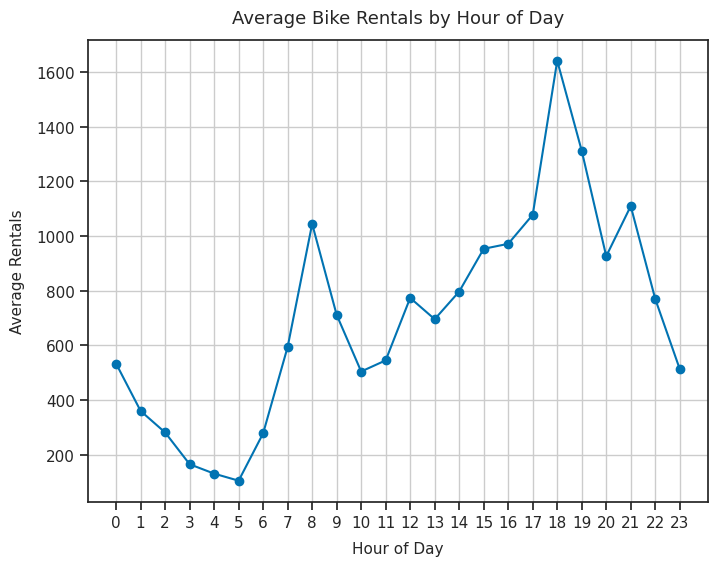

In [7]:
#######
# Peak-Hour behavior
# Understanding peak-hour behavior is important to define what the peak hours
# are in the city of Chicago.
# In Figure 2, the demand on peak vs. non-peak hours is studied, including the
# lense of working and non-working days.

#Peak hours defined as:


#  Morning Peak-Hour: 7-9AM
#  Evening Peak-Hour: 4-7PM

# External confirmation: https://www.blacklane.com/en/blog/travel/rush-hour-in-chicago/
#######

# Defining average demand by hour
hourly_demand = (
    bikerentals
    .groupby("hour")["rentals"]
    .mean()
)

# Plotting average bike demand by hour
plt.plot(hourly_demand.index, hourly_demand.values, marker="o") #showing marker
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.title("Average Bike Rentals by Hour of Day")
plt.xticks(range(0,24)) # see ticks in each value
plt.grid(True)

plt.show()

In [8]:
# Defining a new boolean variable to identify rentals within peak hours
bikerentals["is_peak_hour"] = (
    bikerentals["hour"].isin([7, 8, 9, 16, 17, 18,19])
).astype(int)

## Figure 2: Bike Rentals: Peak vs. Non-Peak Hours in Working and Non-Working Days

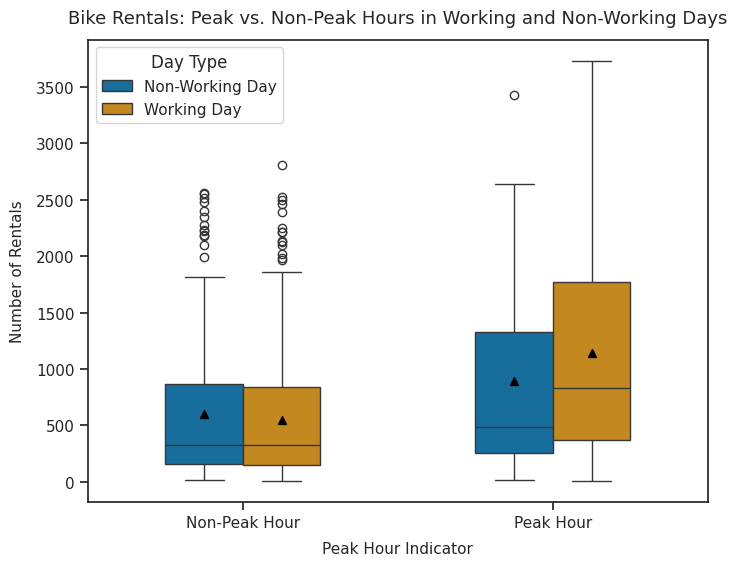

In [9]:
# Understanding if there is a difference between peak and non-peak hours
ax=sns.boxplot(x = 'is_peak_hour',
            y = 'rentals',
            hue = "is_working_day",
            data = bikerentals,
            showmeans=True,
            meanprops=mp,
            width=0.5 # narrower width of the histogram
            )

# x-axis labels
ax.set_xticklabels(["Non-Peak Hour", "Peak Hour"])

plt.title("Bike Rentals: Peak vs. Non-Peak Hours in Working and Non-Working Days")
plt.xlabel("Peak Hour Indicator")
plt.ylabel("Number of Rentals")

# Adding labels to the legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles=handles,
    labels=["Non-Working Day", "Working Day"],
    title="Day Type"
)
plt.show()



In [10]:
# Dividing rain into three categories to analyse if there is a difference in the
# effect of rain in working and non-working days

# Create rainfall bins (light vs heavy rain)
bikerentals["rain_bin"] = pd.cut(
    bikerentals["rainfall"],
    bins=[-0.01,                              # 0: no rain
          0,                                  # 0 - 5: light rain
          5,                                  # > 5: heavy rain
          bikerentals["rainfall"].max()],
    labels=["No rain", "Light rain", "Heavy rain"]
)

## Figure 3: Impact of Rainfall on Bike Rentals by Working Day Status

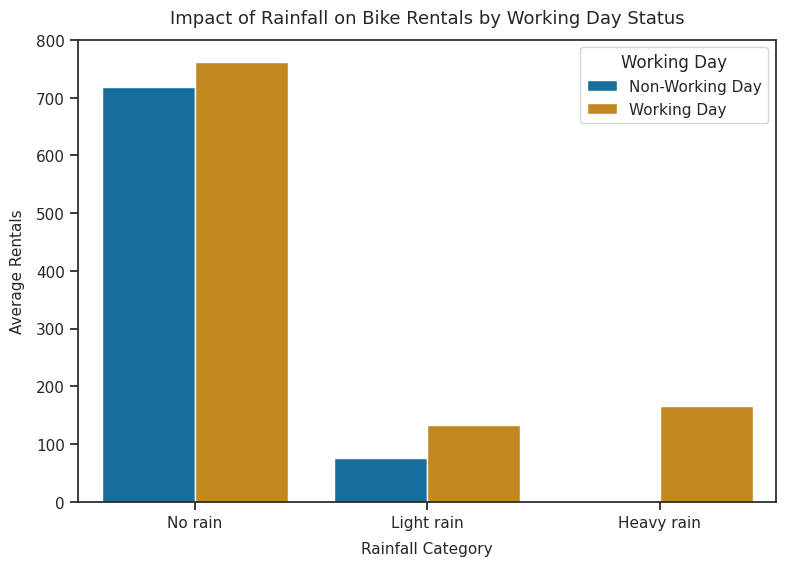

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    x="rain_bin",
    y="rentals",
    hue="is_working_day",
    data=bikerentals,
    errorbar=None # delete Confidence Interval lines
   )

ax.set_title("Impact of Rainfall on Bike Rentals by Working Day Status")
ax.set_xlabel("Rainfall Category")
ax.set_ylabel("Average Rentals")
ax.set_xticklabels(["No rain", "Light rain", "Heavy rain"])
ax.legend(title="Working Day", labels=["Non-Working Day", "Working Day"])

plt.show()


# Temperature: the Most Influential Weather Driver of Bike-Sharing Demand

**Temperature has the strongest effect on bike rental demand**. To reach this conclusion, the relative importance of weather conditions was assessed using a linear regression with all standardized meteorological variables as described in Figure 4 (dew_point_temperature was excluded due to high correlation with other variables). The importance of weather variables is evaluated based on the magnitude of the standardized coefficient rather than statistical significance alone. Each coefficient represents the expected change in rentals associated with one standard deviation increase in that weather variable, holding other weather variables constant.

Temperature has the largest standardized coefficient (figure 5), indicating it has the strongest association with bike rentals among the weather variables considered. This suggests that temperature comfort is a primary driver of bike demand, as riders are more likely to cycle under warmer conditions. This finding aligns with previous research that shows temperature is a dominant determinant of bike sharing: “coldest days are associated with reduced bikeshare trip times”(Park, 2021, p. 18). Humidity and wind speed also display meaningful negative effects on demand, consistent with increased physical discomfort and effort during cycling under humid or windy conditions.



In [12]:
# All weather variables excluding dew_point_temperature due to multicollinearity\
# found with temperature and humidity (correlation shown in appendix)
weather_variables = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "uv_index",
    "rainfall",
    "snowfall"
]

In [13]:
# Preparing the data for the the linear model

# x-side
x_weather = bikerentals[weather_variables]

# y-side
y_weather = bikerentals['rentals']

In [14]:
# Defining the x and y data and splitting the dataset into training and test sets

# x-data
x_data = x_weather

# y_data
y_data = y_weather

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.35,
                                                    random_state = 702 )

In [15]:
#######
# Standardising the weather variables to compare different sizes
# Because the model use is not to predict but to understand the main weather driver for demand
# an standardized regression is best. The interpretation is not the same:
# each coefficient represents the expected change in bike rentals associated with
# a one–standard deviation increase in the corresponding weather variable
#######

# Using the StandardScaler class from sklearn
scaler = StandardScaler()

# Standardising the training set
x_training_scaled = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns=weather_variables,
    index=x_train.index
)

x_test_scaled = pd.DataFrame(
    scaler.fit_transform(x_test),
    columns=weather_variables,
    index=x_test.index
)

## Figure 4: Linear Regression Model Including Only Weather Variables

In [16]:
# Naming the model
model_name = "Linear Regression Weather Only"

# Instantiating model object
model = sklearn.linear_model.LinearRegression()

# Fitting to training data
model_fit = model.fit(x_training_scaled, y_train)

# Predicting on new data
model_pred = model.predict(x_test_scaled)

# Scoring results (R-Square)
model_train_score = round(model.score(x_training_scaled, y_train), ndigits = 4)
model_test_score  = round(model.score(x_test_scaled, y_test), ndigits = 4)
model_gap         = round(model_train_score - model_test_score, ndigits = 4)

# Displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

Training Score : 0.5732
Testing Score  : 0.5801
Train-Test Gap : -0.0069


## Figure 5: Linear Regression Model Coefficients

In [17]:
# Zipping each feature name to its coefficient
model_coefficients = zip(x_train.columns,
                         model.coef_.round(decimals = 4))


# Setting up a placeholder list to store model features
coefficient_lst = [('intercept', model.intercept_.round(decimals = 4))]


# Printing out each feature-coefficient pair one by one
for coefficient in model_coefficients:
    coefficient_lst.append(coefficient)

# Dynamically printing coefficients
ols_coefficients =  f"""\
Coefficents
-----------
{pd.DataFrame(data = coefficient_lst, columns = ["Feature", "Coefficient"])}"""
print(ols_coefficients)


Coefficents
-----------
       Feature  Coefficient
0    intercept     699.2740
1  temperature     578.3906
2     humidity    -192.7784
3   wind_speed      78.9191
4   visibility      80.6212
5     uv_index    -104.7202
6     rainfall     -60.0851
7     snowfall      39.7040


In [18]:
# Reviewing the coefficients and p-values with smf
# To remain consistent with the predictive modeling framework, \
# the weather-only model was estimated on the training sample

# Add rentals to the x_training_scaled set
x_training_scaled["rentals"] = bikerentals["rentals"]

# Instantiating model object
lm = smf.ols(formula =  """rentals ~ temperature +
                                   humidity +
                                   wind_speed +
                                   visibility +
                                   uv_index +
                                   rainfall +
                                   snowfall""",
            data = x_training_scaled)


# Fitting to data (in this case, training data)
results = lm.fit()


# Analyzing the summary output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     126.6
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          1.42e-117
Time:                        05:53:41   Log-Likelihood:                -5061.4
No. Observations:                 668   AIC:                         1.014e+04
Df Residuals:                     660   BIC:                         1.017e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     699.2740     18.392     38.021      

# Identifying Low-Demand Periods for Bike Maintenance Using a Regression Tree

Efficient bike maintenance requires identifying periods of consistently low demand to minimise disruption to users. A regression tree was developed to identify interpretable, actionable conditions under which bike rental demand is lowest while covering at least 10% of the dataset to ensure meaningful and operationally viable maintenance planning. Average bike rentals across the full dataset are approximately 710 per period. The low-demand nodes identified by the regression tree consistently fall far below this level, including some below 200 rentals, indicating periods of exceptionally low system usage (Figure 6).

**Path: Late-night / early-morning periods under cold conditions.**
When bike rentals occur before 6 AM and temperatures fall below approximately 3°C, average demand drops to very low levels (around 105 rentals). These conditions correspond to periods with minimal rider activity, reflecting both reduced commuting and limited discretionary travel. This node includes 92 observations, representing approximately 13.8% of the dataset (92 out of 668 training observations), comfortably exceeding the 10% threshold required. As such, these time windows present a clear and reliable opportunity for maintenance with minimal impact on users.

Other branches of the regression tree identify additional periods with below average demand; however, they exhibit higher average usage than the described path or cover smaller portions of the dataset. Therefore, the early-morning, cold-weather window provides the most robust and operationally efficient condition for maintenance scheduling in accordance with the training data.




In [19]:
# Creating the columns that will be used for the tree model
# The main objective is to understand low demand buckets to do maintenance om the bikes
# therefore the variables need to be easy to interpret and have an actionable component

# Chosen variables
tree_features = [
    "hour",
    "is_working_day",
    "holiday",
    "temperature",
    "rainfall",
    "snowfall"
]

In [20]:
# Preparing the data for the the tree model

# x-side
x_base = bikerentals[tree_features]

# y-side
y_original = bikerentals['rentals']

In [21]:
# Defining the x and y data and splitting the dataset into training and test sets

# x-data
x_data = x_base

# y_data
y_data = y_original

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                          test_size = 0.35,
                                          random_state = 702)

In [22]:
# Naming the model
model_name = 'Pruned Regression Tree to Identify Low Demand'

# Instantiating model object
# Objective is to avoids overfitting and improve interpretability
model = DecisionTreeRegressor(max_depth=5,
                              min_samples_leaf=30, # bigger leafs
                              random_state = 702)

# Fitting to training data
model_fit = model.fit(x_train, y_train)

# Predicting on new data
model_pred = model.predict(x_test)

# Scoring results (R-Square)
model_train_score = model.score(x_train, y_train)
model_test_score  = model.score(x_test, y_test)
model_gap         = abs(model_train_score - model_test_score)

# Displaying results
print('Training Score :', round(model_train_score, ndigits = 4))
print('Testing Score  :', round(model_test_score, ndigits = 4))
print('Train-Test Gap :', round(model_gap, ndigits = 4))

Training Score : 0.7139
Testing Score  : 0.6796
Train-Test Gap : 0.0344


## Figure 6: Pruned Regression Tree to Identify Low Demand

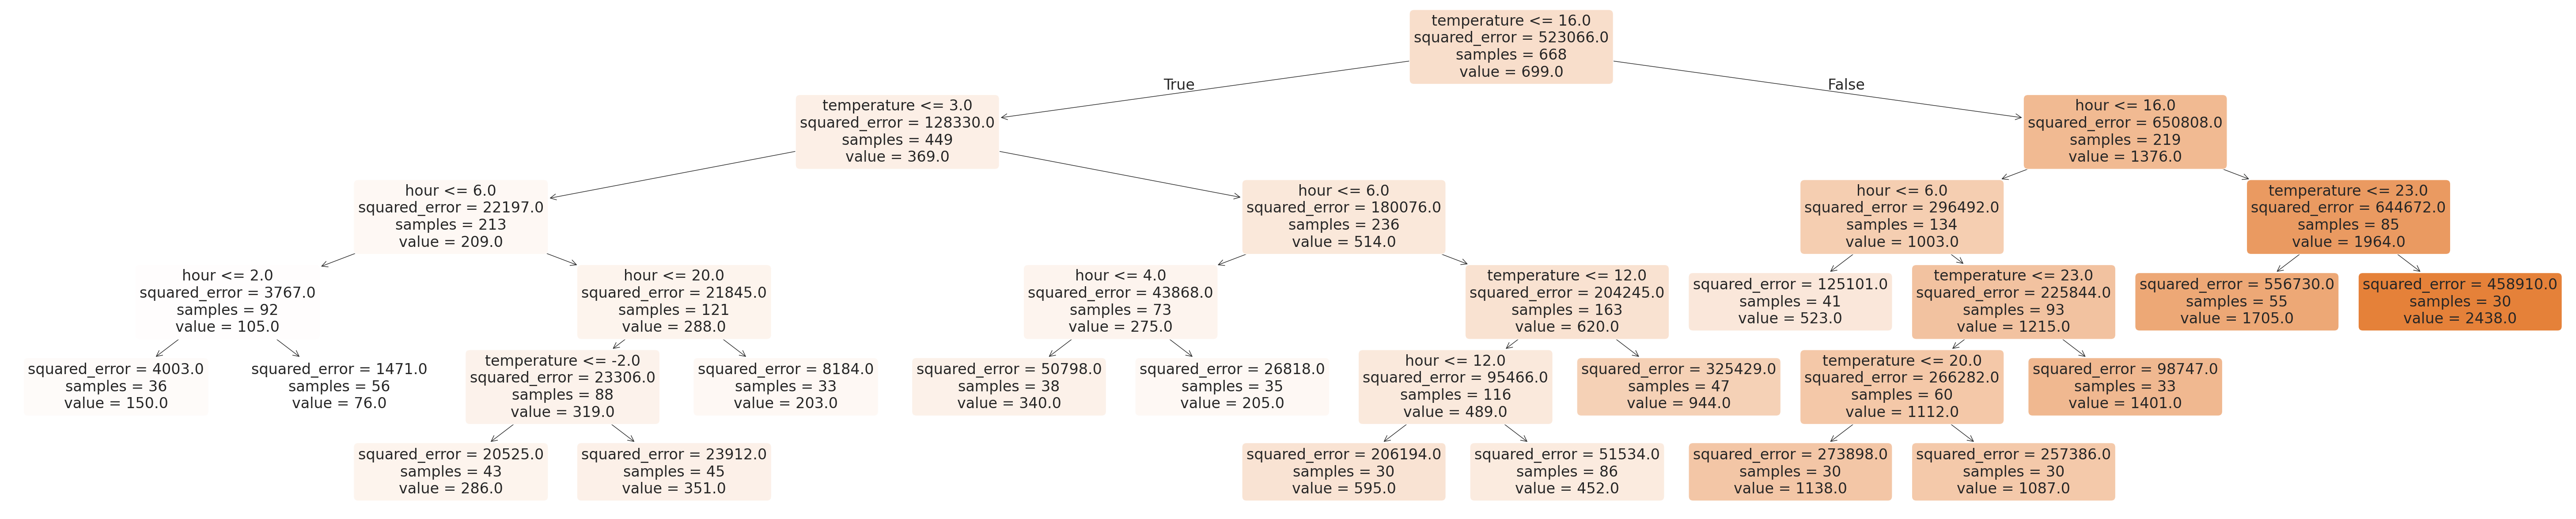

In [23]:
# Displaying the tree

# Setting figure size
plt.figure(figsize=(75, 15)) #big enough to see the whole tree

# Developing a plotted tree
plot_tree(decision_tree = model,
          feature_names = x_train.columns,
          filled        = True,
          rounded       = True,
          fontsize      = 24,
          precision     = 0)

# Rendering the plot
plt.show()

# Final Model to Predict Rental Demand in Real Time

The final linear regression model explains approximately 79–80% of the variation in bike rental demand on both the training and test sets, indicating strong and stable predictive performance (Figure 7).

Adding interaction terms meaningfully improves the model, showing that demand responds differently depending on time of day, working-day context, and weather conditions. Peak-hour demand on working days is one of the strongest drivers of rentals, reinforcing the importance of commuting behavior in overall system usage. Weather effects are conditional: precipitation and humidity reduce demand more strongly during non-peak and evening periods, while peak-hour commuting demand remains comparatively resilient. Residual analysis (Figure 8) suggests that the model captures low-demand periods reasonably well, supporting its use for operational planning and real-time demand estimation.

In [24]:
# Creating a dataset to be used in the linear regression to predict bike rental demand
bikerentals_complete = bikerentals.copy()

In [25]:
########
# One hot encoding categorical variables
# Each categorical variable has been plotted to understand if there is variability
# in each category (see appendix)
# Each category has also been assesed to ensure that at least contains 30 observations
# (see appendix)
# Only using month dummies to later create an interaction
########

# Month one-hot encoding
one_hot_month = pd.get_dummies(
    bikerentals_complete["month"],
    prefix="month",
    dtype=int
)

# Join dummies to main dataframe
bikerentals_complete = bikerentals_complete.join(one_hot_month)

# Rename month columns for consistency
bikerentals_complete.rename(
    columns={
        "month_Jan": "jan",
        "month_Feb": "feb",
        "month_Mar": "mar",
        "month_Apr": "apr",
        "month_May": "may",
        "month_June": "jun"
    },
    inplace=True
)

# Drop January to serve as baseline category
bikerentals_complete = bikerentals_complete.drop(
    columns=["jan"])

In [26]:
# Create time-of-day indicators to capture nonlinear hourly demand patterns
# 3 indicators are defined to reflect distinct usage behaviors
bikerentals_complete["is_morning"] = bikerentals_complete["hour"].between(0, 10).astype(int)
bikerentals_complete["is_afternoon"] = bikerentals_complete["hour"].between(11, 16).astype(int)
bikerentals_complete["is_evening"] = bikerentals_complete["hour"].between(17, 23).astype(int)
bikerentals_complete = bikerentals_complete.drop(['is_morning'
                          ], axis = 1)

In [27]:
#########
# Initial model diagnostics (including residual patterns) showed that the model
# baseline OLS model tended to overpredict for high demand periods and under
# predict for low demand periods. Creating interaction between variables to
# capture effects that are nonlinear or conditional as demand responds
# differently depending on time context and weather conditions.
#########

# Peak-hour and working-day interaction
# Peak-hour demand behaves differently on working days (commuting effect)
bikerentals_complete["peak_work_interaction"] = (
    bikerentals_complete["is_peak_hour"] *
    bikerentals_complete["is_working_day"]
)

# Temperature and humidity interaction
# Provides an actual proxy of how the weather feels
bikerentals_complete["temperature_humidity_interaction"] = (
    bikerentals_complete["temperature"] *
    bikerentals_complete["humidity"]
)

# Indicator for any precipitation (rain or snow)
bikerentals_complete["is_precipitation"] = (
    (bikerentals_complete["rainfall"] > 0) |
    (bikerentals_complete["snowfall"] > 0)
).astype(int)

# Interaction: rainfall and is_evening
# Rainfall impact during evening (higher demand during peak and more discretionary use after)
bikerentals_complete['rainfall_evening'] = (
    bikerentals_complete['rainfall'] * bikerentals_complete['is_evening']
)

# Snowfall impact outside of peak hours
# Need to create non-peak hours first
bikerentals_complete['is_non_peak'] = 1 - bikerentals_complete['is_peak_hour']

bikerentals_complete['snowfall_non_peak'] = (
    bikerentals_complete['snowfall'] * bikerentals_complete['is_non_peak']
)

# Interaction between temperature and afternoon period
# Allows to capture when temperature differs during midday usage
bikerentals_complete['temp_afternoon'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_afternoon']
)

# Interaction between temperature and evening period
#  Allows to capture when temperature differs during evening usage
bikerentals_complete['temp_evening'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_evening']
)

# Interaction between rainfall and peak hours
# Models whether commuting demand is more resilient to rainfall (as seen in previous analysis)
bikerentals_complete['rainfall_peak'] = (
    bikerentals_complete['rainfall'] * bikerentals_complete['is_peak_hour']
)

# Interaction between temperature and peak hours
# Captures whether temperature influences commuter behavior differently
# during peak travel times
bikerentals_complete['temp_peak'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_peak_hour']
)

In [28]:
# Creating month intensity index
# Encodes progression within the months to capture gradual
# changes in demand not fully represented by binary month indicators
# (see histogram in appendix)
# January and February show very low demand = 0
bikerentals_complete['month_index'] = (
    bikerentals_complete['mar'] * 1 +
    bikerentals_complete['apr'] * 2 +
    bikerentals_complete['may'] * 3 +
    bikerentals_complete['jun'] * 4
)

In [29]:
# Preparing the data for the the linear model

# x-side
x_all = bikerentals_complete[
    ['humidity',
     'wind_speed',
     'dew_point_temperature',
     'is_peak_hour',
     'peak_work_interaction',
     'is_afternoon',
     'is_evening',
     'temperature_humidity_interaction',
     'is_precipitation',
     'rainfall_evening',
     'snowfall_non_peak',
     'temp_afternoon',
     'temp_evening',
     'rainfall_peak',
     'temp_peak',
     'month_index']]

# y-side
y_original = bikerentals_complete['rentals']

In [30]:
# Defining the x and y data and splitting the dataset into training and test sets

# x-data
x_data = x_all

# y_data
y_data = y_original

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.35,
                                                    random_state = 702 )

## Figure 7: Linear Regression Demand Prediction

In [31]:
# Naming the model
model_name = "Linear Regression Demand Prediction"


# Instantiating model object
model = sklearn.linear_model.LinearRegression()


# Fitting to training data
model_fit = model.fit(x_train, y_train)


# Predicting on new data
model_pred = model.predict(x_test)

# Scoring results (R-Square)
model_train_score = round(model.score(x_train, y_train), ndigits = 4)
model_test_score  = round(model.score(x_test, y_test), ndigits = 4)
model_gap         = round(model_train_score - model_test_score, ndigits = 4)


# Displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

Training Score : 0.7796
Testing Score  : 0.804
Train-Test Gap : -0.0244


In [32]:
# Checking coefficients and p-values
# Step 1: INSTANTIATE a model object
lm = smf.ols(  formula="""
        rentals ~
        humidity +
        wind_speed +
        dew_point_temperature +
        is_peak_hour +
        peak_work_interaction +
        is_afternoon +
        is_evening +
        temperature_humidity_interaction +
        is_precipitation+
        rainfall_evening+
        snowfall_non_peak+
        temp_afternoon+
        temp_evening+
        rainfall_peak+
        temp_peak+
        month_index
    """,
            data = bikerentals_complete)


# Step 2: FIT the data into the model object
results = lm.fit()


# Step 3: analyze the SUMMARY output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     236.3
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        05:53:44   Log-Likelihood:                -7425.9
No. Observations:                1029   AIC:                         1.489e+04
Df Residuals:                    1012   BIC:                         1.497e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [33]:
# Residual Analysis

# Organizing residuals
model_residuals = {
    "True"            : y_test,
    "Predicted"       : model_pred.round(decimals = 0).astype(dtype = int)
}


# Converting residuals into a df
resid_df = pd.DataFrame(data = model_residuals)

### Figure 8: Residual Plot

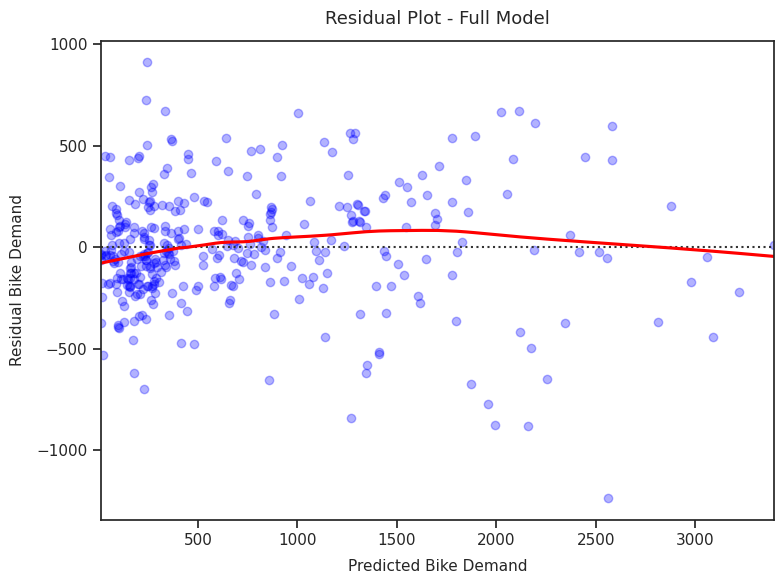

In [34]:
# Developing a residual plot
sns.residplot(data        = resid_df,
              x           = 'True',
              y           = 'Predicted',
              lowess      = True,
              color       = 'blue',
              scatter_kws = {'alpha': 0.3},   # data point transparency
              line_kws    = {'color': 'red'}) # line color


# Title and axis labels
plt.title(label   = "Residual Plot - Full Model")
plt.xlabel(xlabel = "Predicted Bike Demand")
plt.ylabel(ylabel = "Residual Bike Demand")


# Layout and rendering visual
plt.tight_layout()
plt.show()

The residual plot shows that errors are centered around zero across most predicted demand levels, indicating no severe systematic bias in the model. However, the smoothed trend line suggests mild underprediction at very high demand levels and slight overprediction at very low demand levels, which is common in demand forecasting problems. The spread of residuals increases as predicted demand rises, indicating some heteroscedasticity, particularly during peak usage periods. Overall, while variability increases at higher demand levels, the residual pattern remains reasonably stable, supporting the model’s suitability for operational and planning use rather than exact point prediction.

# References
Bergman, Z., Allenspach, N., & Bergman, M. M. (2024). A tale of two Divvys: The bicycle sharing system of Chicago. *Sustainability, 16*(5), 2146. https://doi.org/10.3390/su16052146

OpenAI. (2025). ChatGPT (GPT-5.2) [Large language model]. https://chat.openai.com/

Park, S. (2021). *The effect of weather on travel modes: A Chicago case study* (Master’s thesis). Cornell University. https://ecommons.cornell.edu/server/api/core/bitstreams/39f16028-06da-4d30-8704-c2ece917860f/content

Yang, S., Brakewood, C., Nicolas, V., & Sion, J. (2019). Bikeshare users on a budget? Trip chaining analysis of bikeshare user groups in Chicago. *Transportation Research Record, 2673*(6), 1–12. https://doi.org/10.1177/0361198119838261



# AI Usage Discclosure and Conversation

Generative AI (ChatGPT, GPT-5.2 by OpenAI) was used as a support tool during this project to assist with code debugging, clarification of statistical concepts, figure interpretation, and citation formatting. All data analysis, modeling decisions, interpretations, and written conclusions were independently developed by the author. The AI tool did not generate original data, run analyses, or make final methodological decisions

LLM Conversation: https://chatgpt.com/share/693fa112-21b8-800c-9e4a-f24e7c5d4006


# Appendix

## Categorical variables
Understanding how categorical variables behave

### Month
- Data available from January to June
- Over 30 obersvations in each month
- Definetly differences in rental medians and means across months:
  -  January and February are the months with les rentals
  - June is the month with most rentals
  - We ca see seasonality, meaning that months with generally better weather are months with more demand for rentals


In [35]:
bikerentals["month"].value_counts()

,count
month,
Jan,189
May,181
Apr,173
Mar,166
Feb,162
June,158


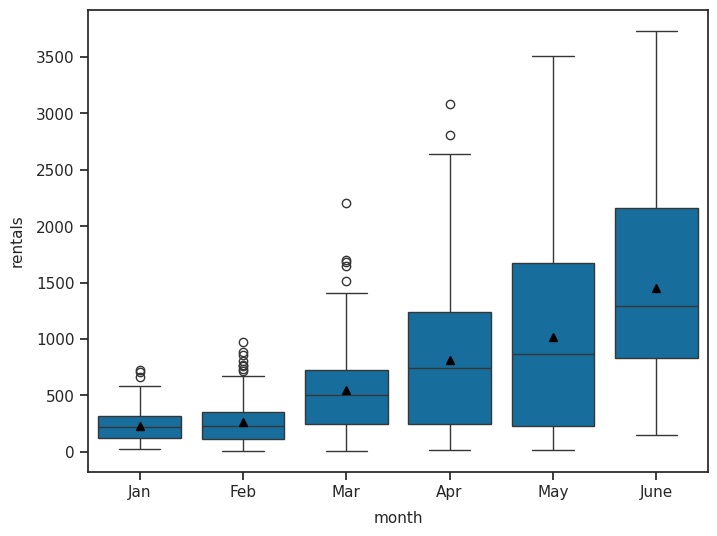

In [36]:
sns.boxplot(x = 'month',
            y = 'rentals',
            data = bikerentals,
            showmeans=True,
            meanprops=mp)

plt.show()

### Day of week
- Over 30 observations for each day of the week
- Differences in rental medians and means across days of week:
  - Tuesday and Wednesdays as the days with less rentals
  - Other days have closer means, with Monday being the day with higher usage

In [37]:
bikerentals["day_of_week"].value_counts()

,count
day_of_week,
Monday,161
Friday,161
Saturday,158
Thursday,149
Tuesday,138
Wednesday,136
Sunday,126


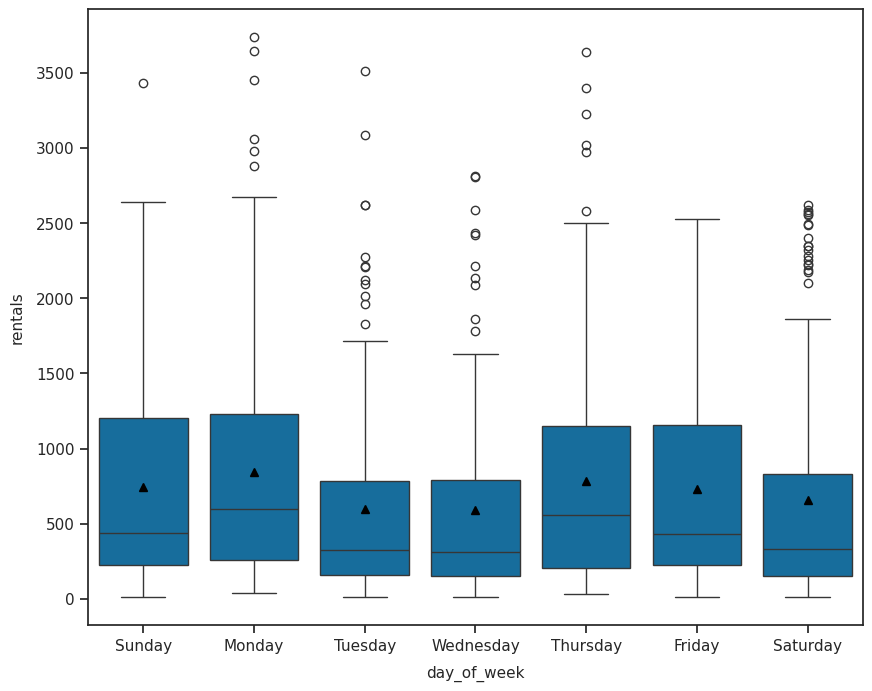

In [38]:
# Plotting the histogram
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(x    = 'day_of_week',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

plt.suptitle("")
plt.show()

In [39]:
bikerentals.groupby("day_of_week")["rentals"].mean().sort_values()

,rentals
day_of_week,
Wednesday,589.860294
Tuesday,594.427536
Saturday,660.405063
Friday,732.677019
Sunday,743.952381
Thursday,781.369128
Monday,843.285714


### Season
- More observations for spring but still over 30 observations for each season
- Seasonal patterns confirmed with seasons:
  - Summer has the highest demand for rental bikes
  - Winter has the lower demand

In [40]:
bikerentals["seasons"].value_counts()

,count
seasons,
Spring,520
Winter,351
Summer,158


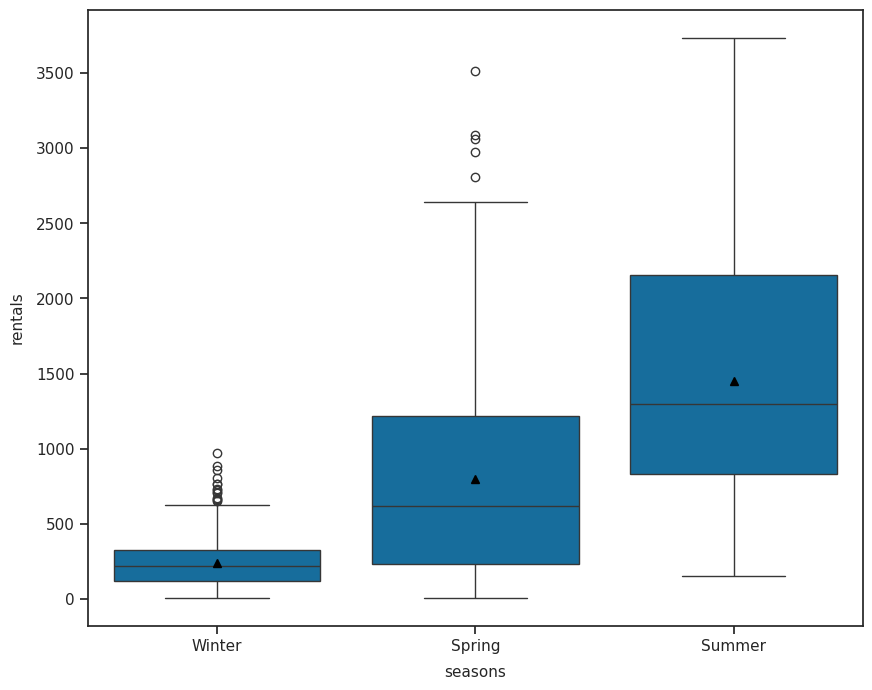

In [41]:
# Plotting the histogram
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(x    = 'seasons',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

plt.suptitle("")
plt.show()

## Multicollinearity in weather variables

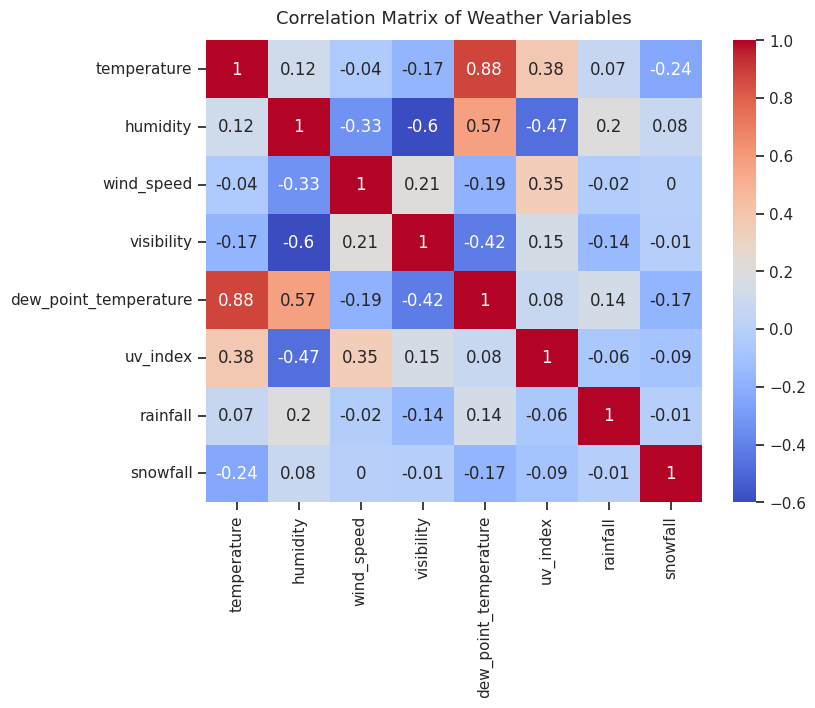

In [42]:
weather_vars = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temperature",
    "uv_index",
    "rainfall",
    "snowfall"
]
corr_matrix = bikerentals[weather_vars].corr().round(2)

fig, ax = plt.subplots()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm"
)

ax.set_title("Correlation Matrix of Weather Variables")

plt.show()

